# RNN - Norman Vicente
##Analisis de sentimiento en reviews de Kindle

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from keras import backend as K
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
dataset = pd.read_csv('facebook_kindle_reviews.csv')

##Exploracion de datos


In [30]:
dataset.head()

,Unnamed: 0,FBPost,Label
0,0.0,Drug Runners and a U.S. Senator have somethin...,O
1,1.0,"Heres a single, to add, to Kindle. Just read t...",O
2,2.0,If you tire of Non-Fiction.. Check out http://...,O
3,3.0,Ghost of Round Island is supposedly nonfiction.,O
4,4.0,Why is Barnes and Nobles version of the Kindle...,N


In [31]:
dataset.tail()

,Unnamed: 0,FBPost,Label
996,996.0,"I think the point of the commercial is that, e...",P
997,997.0,Kindle 3 is such a great product. I could not ...,P
998,998.0,develop a way to share books! that is a big d...,N
999,999.0,I love my kindle! =),P
1000,NaN,bullshit,N


In [32]:
dataset.dtypes

Unnamed: 0    float64
FBPost         object
Label          object
dtype: object

### NA detection

In [33]:
dataset.isna().sum()

Unnamed: 0    1
FBPost        0
Label         0
dtype: int64

In [3]:
dataset.columns = map(str.lower, dataset.columns)

In [4]:
dataset['fbpost'] = dataset['fbpost'].apply(lambda x: x.lower())
dataset['fbpost'] = dataset['fbpost'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [5]:
dataset = dataset[dataset.label != "O"]

In [64]:
pie = dataset.label.value_counts()
pie

1    641
0     84
Name: label, dtype: int64

In [56]:
df_stats = dataset.groupby(['label']).sum()
df_stats

,unnamed: 0
label,
0,42764.0
1,323343.0


##Balance comentarios positivos y negativos

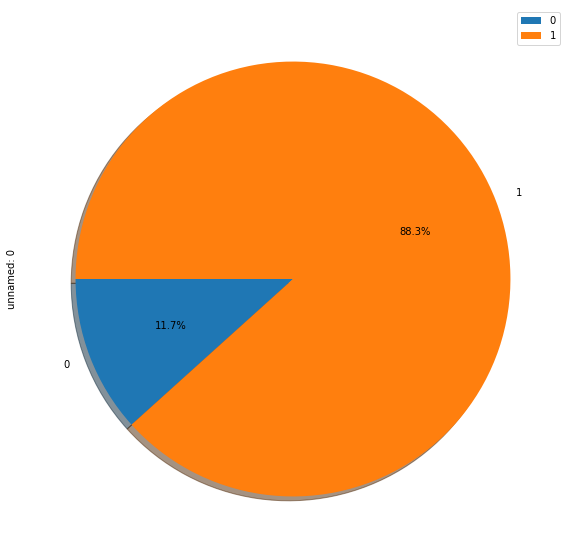

In [62]:
df_stats.groupby(['label']).sum().plot(kind='pie', y='unnamed: 0' , shadow = True, startangle=180, figsize=(15,10), autopct='%1.1f%%')

##Tokenizacion

In [6]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['fbpost'].values)
X = tokenizer.texts_to_sequences(dataset['fbpost'].values)
X = pad_sequences(X)

## OHE

In [8]:
labels = pd.get_dummies(dataset['label']).values

## Train - Test - Val

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,labels, test_size = 0.25, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.1, random_state = 12)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_val.shape,Y_val.shape)

(488, 203) (488, 2)
(182, 203) (182, 2)
(55, 203) (55, 2)


## LSTM Model

In [10]:
embed_dim = 200
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 203, 200)          400000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 203, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 721,202
Trainable params: 721,202
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [11]:
batch_size = 32
RNN = model.fit(X_train, Y_train, epochs = 8, batch_size=batch_size, verbose = 1)

Epoch 1/8
16/16 [==============================] - 23s 1s/step - loss: 0.4776 - accuracy: 0.8566
Epoch 2/8
16/16 [==============================] - 20s 1s/step - loss: 0.3237 - accuracy: 0.8811
Epoch 3/8
16/16 [==============================] - 20s 1s/step - loss: 0.2777 - accuracy: 0.8852
Epoch 4/8
16/16 [==============================] - 20s 1s/step - loss: 0.2082 - accuracy: 0.9221
Epoch 5/8
16/16 [==============================] - 20s 1s/step - loss: 0.1410 - accuracy: 0.9611
Epoch 6/8
16/16 [==============================] - 20s 1s/step - loss: 0.0738 - accuracy: 0.9795
Epoch 7/8
16/16 [==============================] - 20s 1s/step - loss: 0.0530 - accuracy: 0.9898
Epoch 8/8
16/16 [==============================] - 20s 1s/step - loss: 0.0262 - accuracy: 0.9939


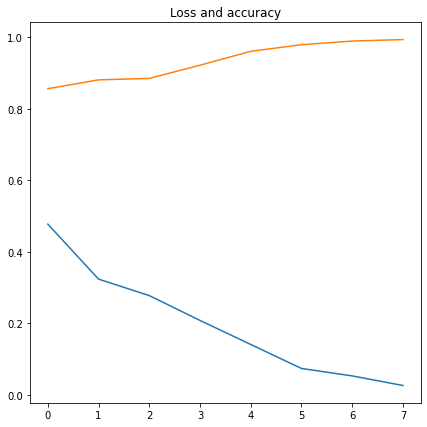

In [65]:
history = pd.DataFrame(RNN.history)
plt.figure(figsize=(7,7));
plt.plot(history["loss"]);
plt.plot(history["accuracy"]);
plt.title("Loss and accuracy");
plt.show();

## Validation set

In [13]:
score,acc = model.evaluate(X_val,Y_val)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

2/2 [==============================] - 1s 229ms/step - loss: 0.3455 - accuracy: 0.9091
score: 0.35
accuracy: 0.91


## Test set

In [19]:
score,acc = model.evaluate(X_test,Y_test)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

6/6 [==============================] - 1s 162ms/step - loss: 0.5645 - accuracy: 0.8791
score: 0.56
accuracy: 0.88


## Predicciones - Random comments

Comentarios nuevos - no han pasado por el entrenamiento

In [47]:
comments =[
           ['love this kindle....'],
           ['I love this collection feature. I use it and really does help me find things quickly.'],
           ['your customer service is the absolute worst i now have a mess of books on my kindle'],
           ['overrated product'],
           ['My Beloved']
]

true_labels = [1,1,0,0,1]

In [48]:
def make_preds(comments):
  predicted_labels = []
  for cmnt in comments:
    cmnt = tokenizer.texts_to_sequences(cmnt)
    cmnt = pad_sequences(cmnt, maxlen=203, dtype='int32', value=0)
    print(cmnt)
    sentiment = model.predict(cmnt,batch_size=2,verbose = 2)[0]
    if(np.argmax(sentiment) == 0):
        print("negative")
        predicted_labels.append(0)
    elif (np.argmax(sentiment) == 1):
        print("positive")
        predicted_labels.append(1)
  return predicted_labels

In [49]:
predicted_labels = make_preds(comments)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  9 17  4]]
1/1 - 0s
positive
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0

In [33]:
predicted_labels, true_labels

([1, 1, 1, 1, 1], [1, 1, 0, 0, 1])

In [45]:
f1_score(true_labels, predicted_labels, average='weighted')

0.4499999999999999

In [44]:
recall_score(true_labels, predicted_labels, average='weighted')

0.6

In [ ]:
dataset['label']= dataset['label'].astype('category')
dataset['label']= dataset['label'].cat.codes
fig = plt.figure(figsize=(6,6), dpi=200)
ax = plt.subplot(111)
dataset.label.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=17)

##Conclusiones

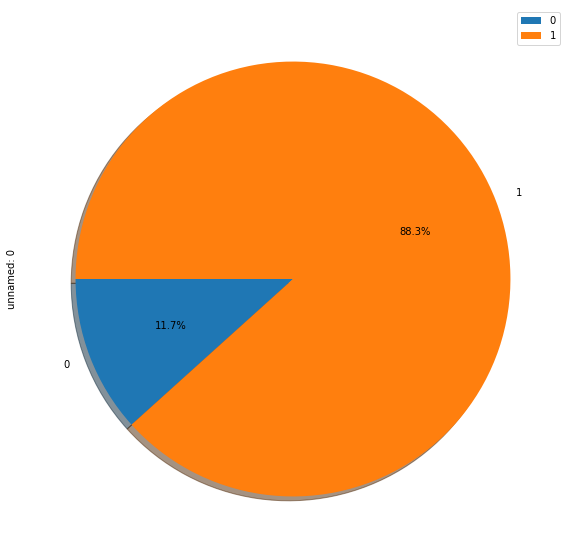

In [63]:
df_stats.groupby(['label']).sum().plot(kind='pie', y='unnamed: 0' , shadow = True, startangle=180, figsize=(15,10), autopct='%1.1f%%')

- Como se puede observar en el grafico el dataset esta desbalanceado por lo tanto aparte de accuracy se calcularon otras metricas como F1, y recall.
- Se trabajo un modelo con capas de Dropout que nos ayudo a reducir el overfitting y LSTM que es un tipo especial de redes recurrentes.
- Al final aparte del test_set se hicieron 5 predicciones donde obtuvimos un F1 de 44%
- Es importante tener en cuanta que no siempre los datos van a tener la forma esperada para este proyecto los dos dataset que eleji ha sido desbalanceados y posiblemente ya en la practica real sea asi por lo tanto desde ya es un problema que tengo presente
- El preprocesamiento de datos es de las cosas que mas trabajo llevan a la hora de realizar este tipo de proyectos por suerte el dataset que use ya tenia un preprocesamiento previo aun asi era un dataset desbalanceado